In [1]:
# ==============================================================
# 1. Import Libraries
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# ==============================================================
# 2. DATA
# ==============================================================

# -------------------------------------------
#STEP1:DATA LOADING
# -------------------------------------------

df = pd.read_csv("../src/london_weather.csv", low_memory=False)

print("Shape:", df.shape)
df.head()

# -------------------------------------------
# STEP2:DATA CLEANING
# -------------------------------------------

#2.1 HANDEL MISSING DATA

df['snow_depth'].fillna(0,inplace=True)
df['precipitation'].fillna(0,inplace=True)
df['pressure'].fillna(df['pressure'].mean(), inplace=True)

#2.2 Add "month" column

df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.sort_values('date')
df.insert(1,'month',df['date'].dt.month)

#2.3 Create Target Column: RainTomorrow (>= 1 mm rain)

df['RainTomorrow'] = df['precipitation'].shift(-1)
df['RainTomorrow'] = (df['RainTomorrow'] >= 1.0).astype(int)
df = df[:-1] 

#2.4 DROP ROWS MISSING ESSENTIAL FIELDS

df.dropna(subset=['cloud_cover'], inplace=True)
df.dropna(subset=['max_temp'], inplace=True)
df.dropna(subset=['global_radiation'], inplace=True)
df.dropna(subset=['min_temp'], inplace=True)

#2.5 HANDEL MISSING DATA(mean_temp)

for index, row in df.iterrows():
        if pd.isna(row['mean_temp']):
           
            target_col_index = df.columns.get_loc('mean_temp')
            
            # Ensure there are at least two columns after the target column
            if target_col_index + 2 < len(df.columns):
                next_col_1 = df.columns[target_col_index + 1]
                next_col_2 = df.columns[target_col_index -1]

                # Calculate the mean of the next two columns in the current row
                mean_value = (row[next_col_1] + row[next_col_2]) / 2
                
                # Replace the NaN value
                df.loc[index, 'mean_temp'] = mean_value



Shape: (15341, 10)


/tmp/ipykernel_22634/2840302771.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['snow_depth'].fillna(0,inplace=True)
/tmp/ipykernel_22634/2840302771.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

SEPERATE TARGET AND PREDICTORS
X shape: (15295, 10)
y shape: (15295,)
TRAIN/TEST SPLIT
Training set shape: (12236, 10)
Testing set shape: (3059, 10)
y_train shape: (12236,)
y_test shape: (3059,)


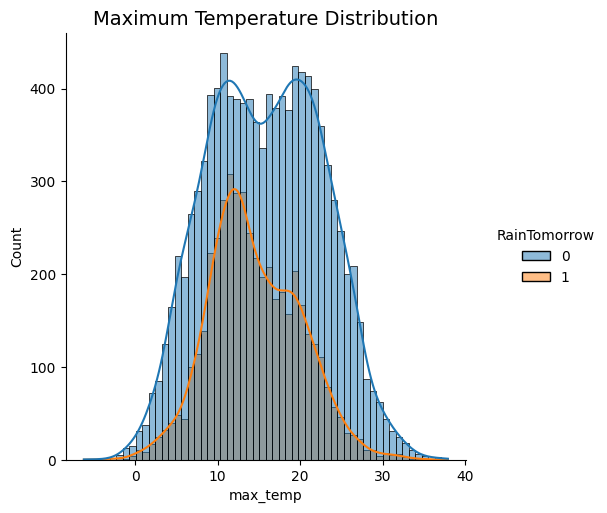

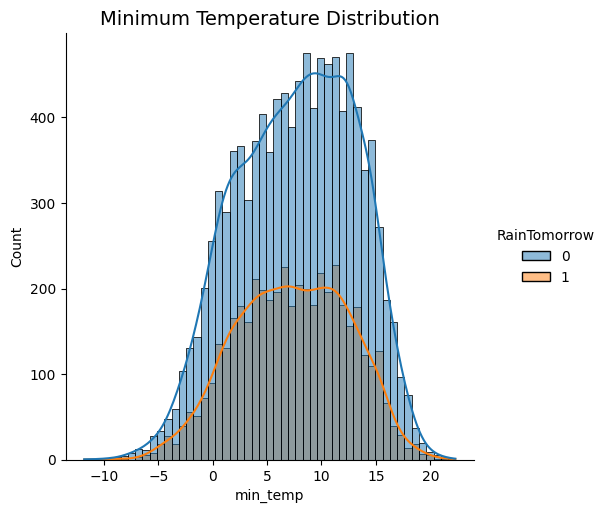

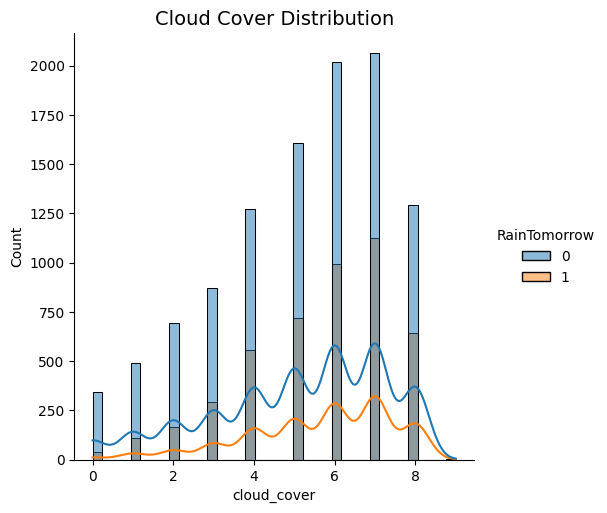

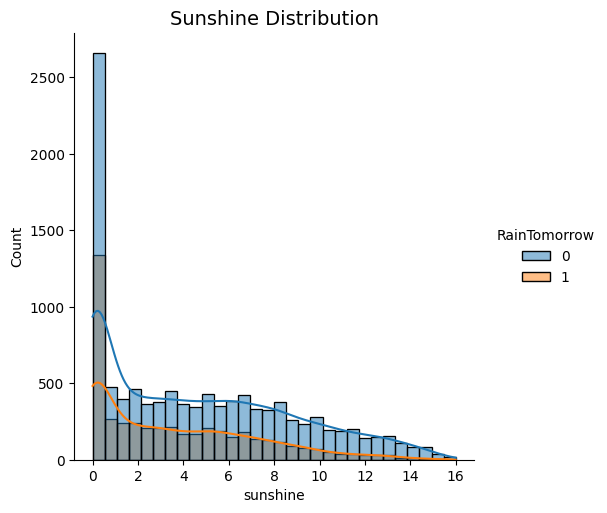

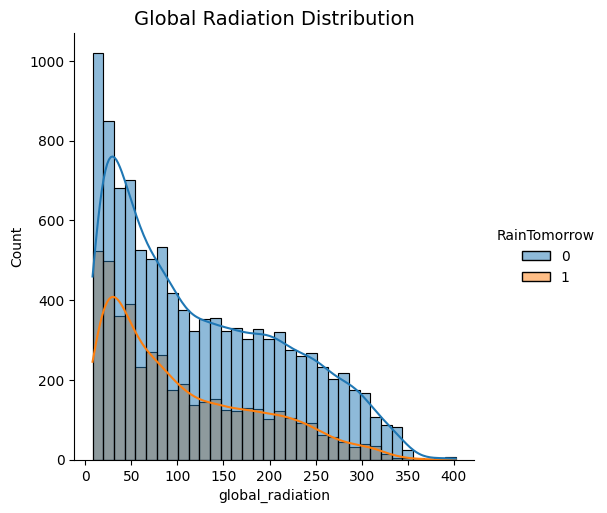

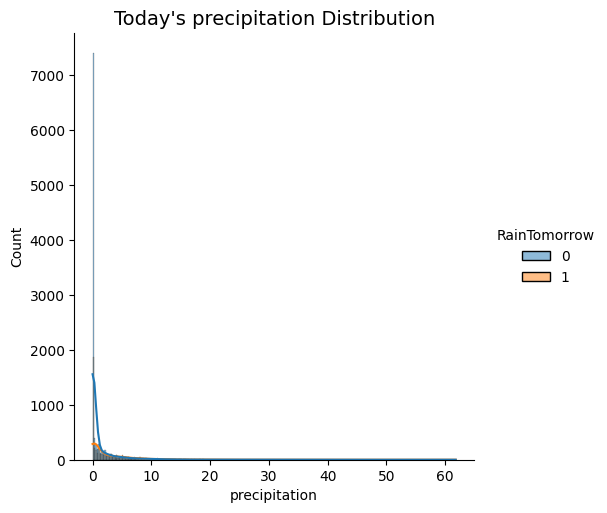

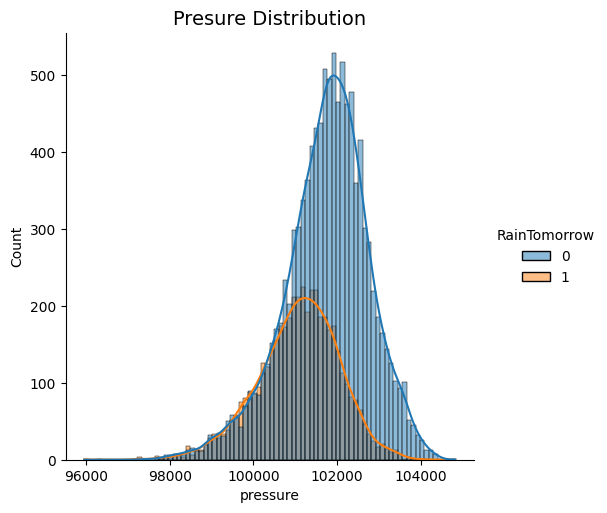

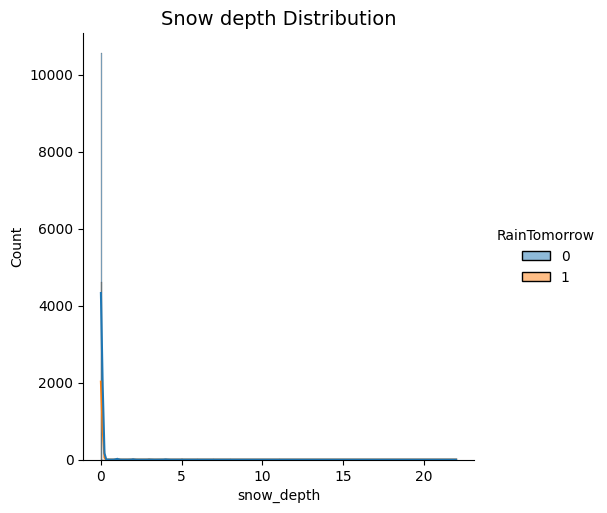

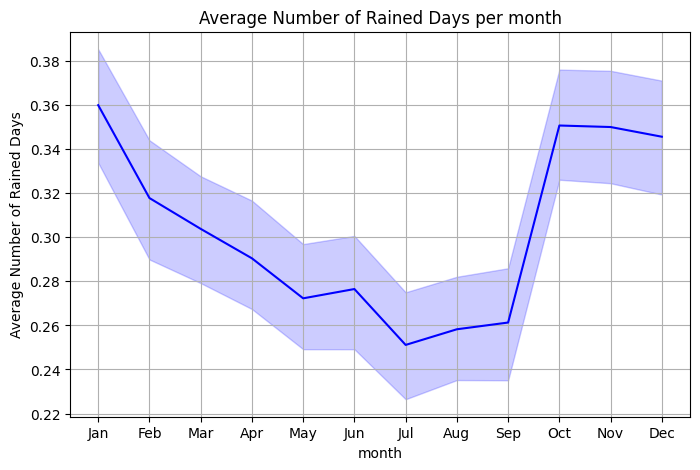

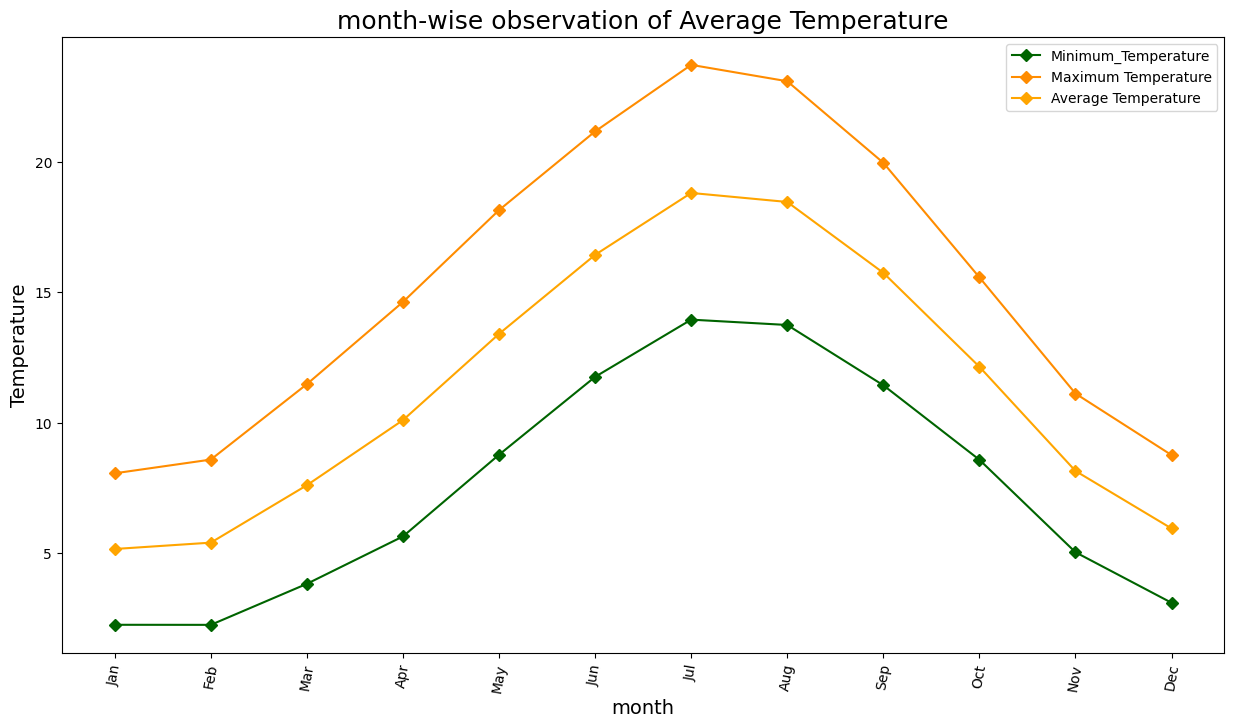

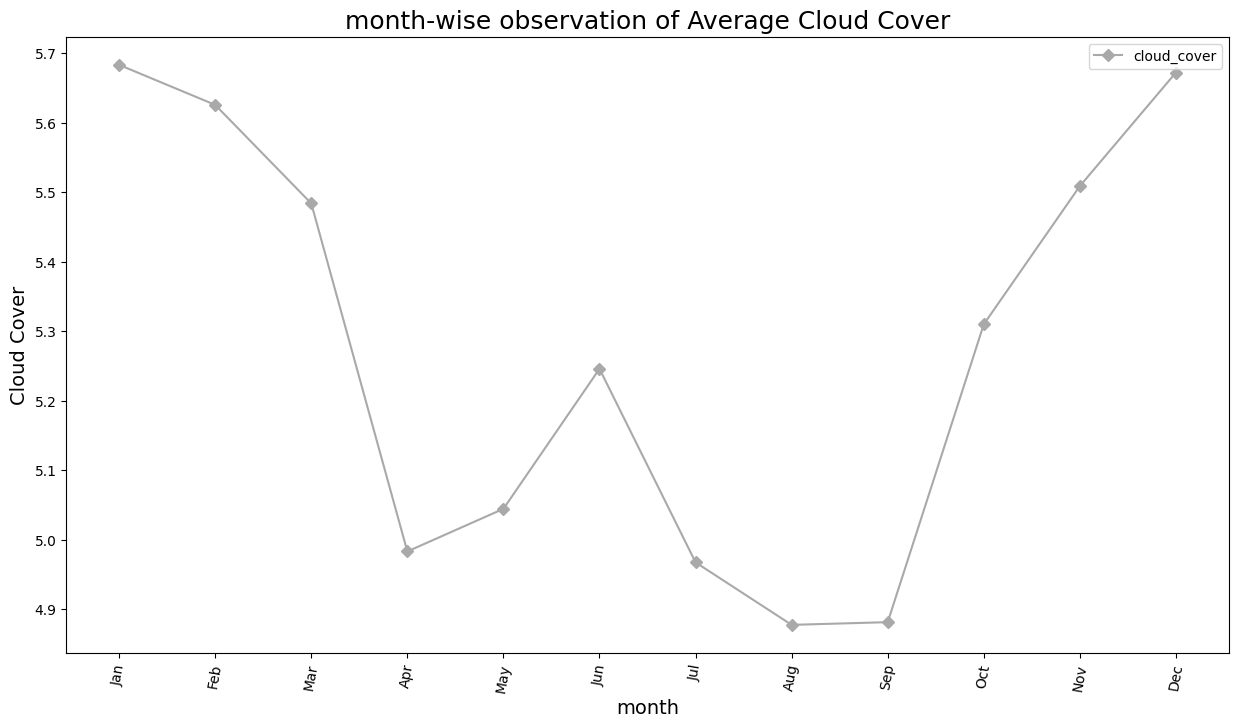

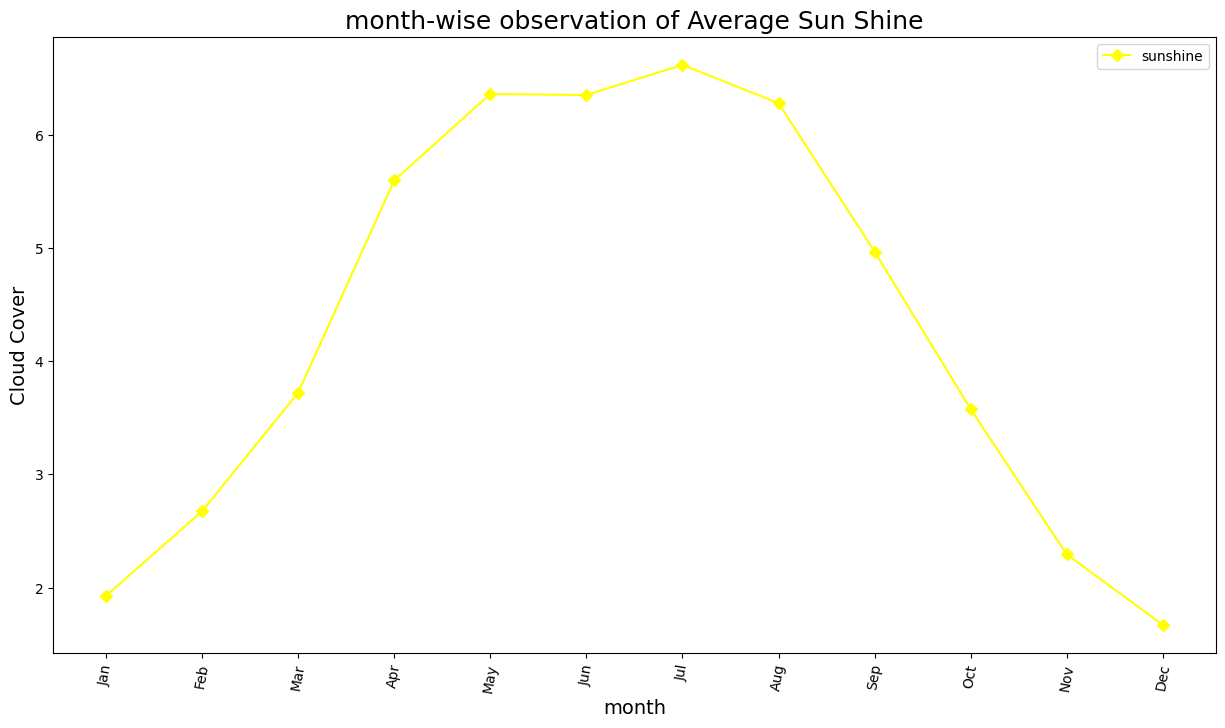

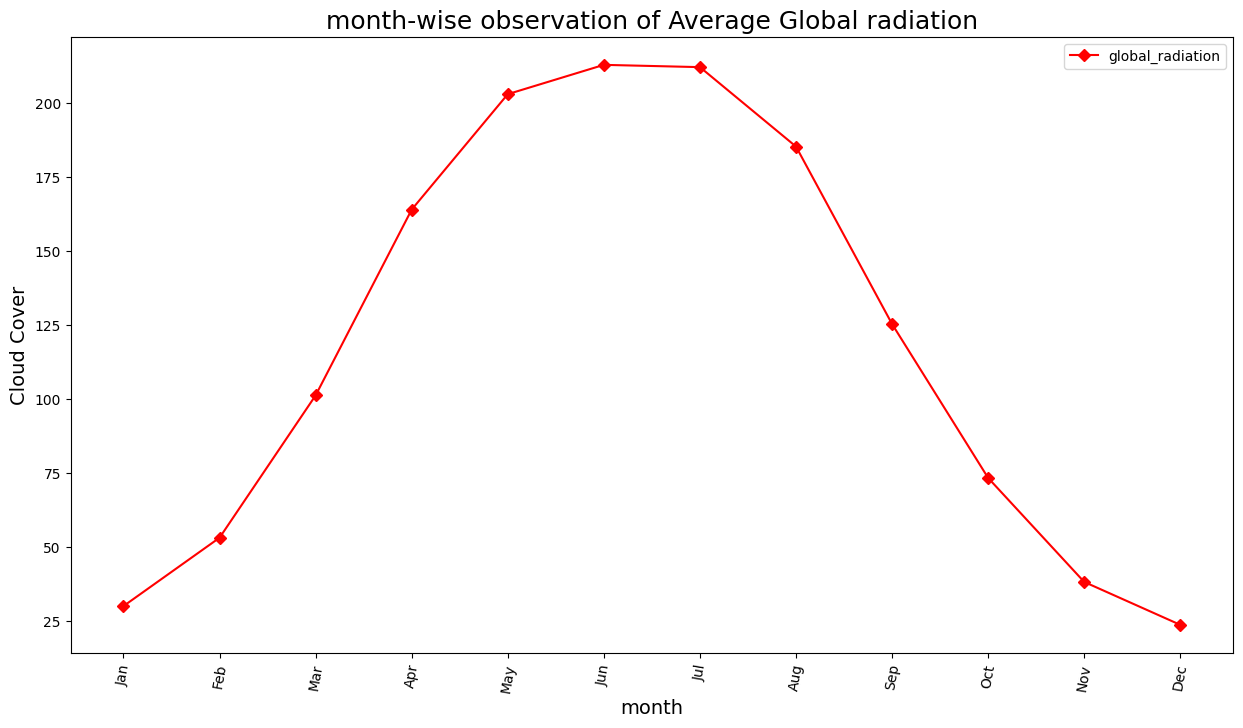

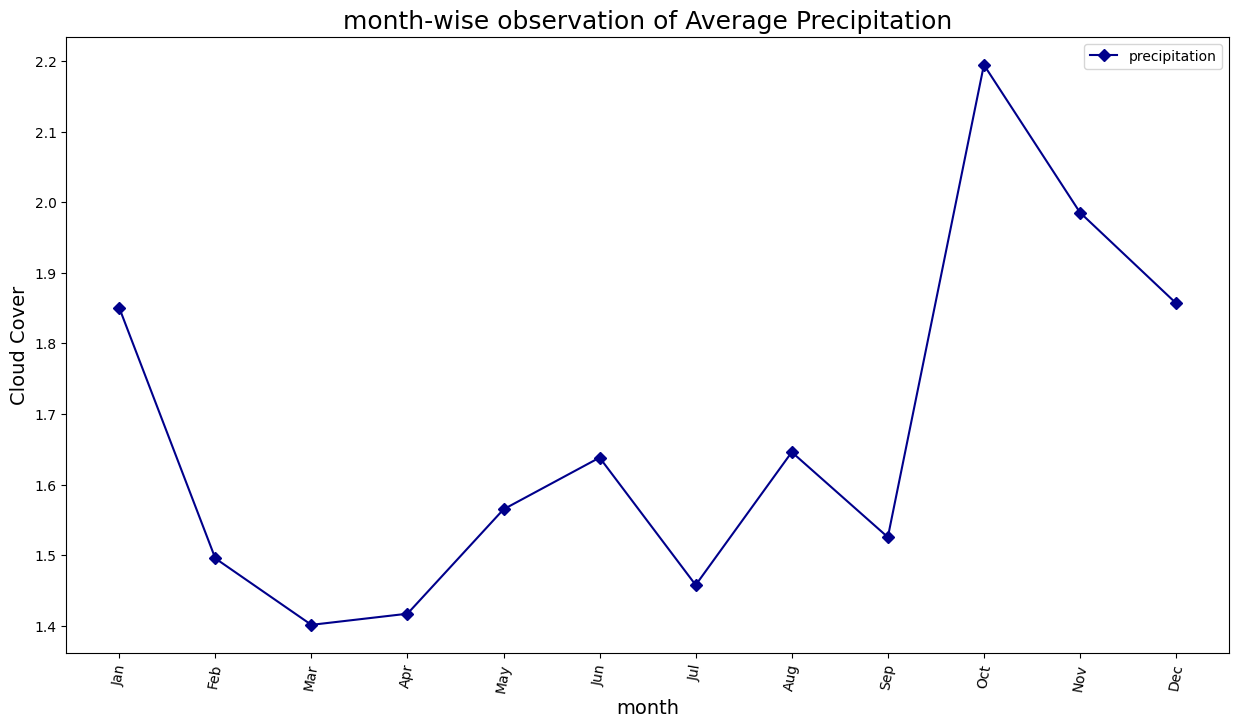

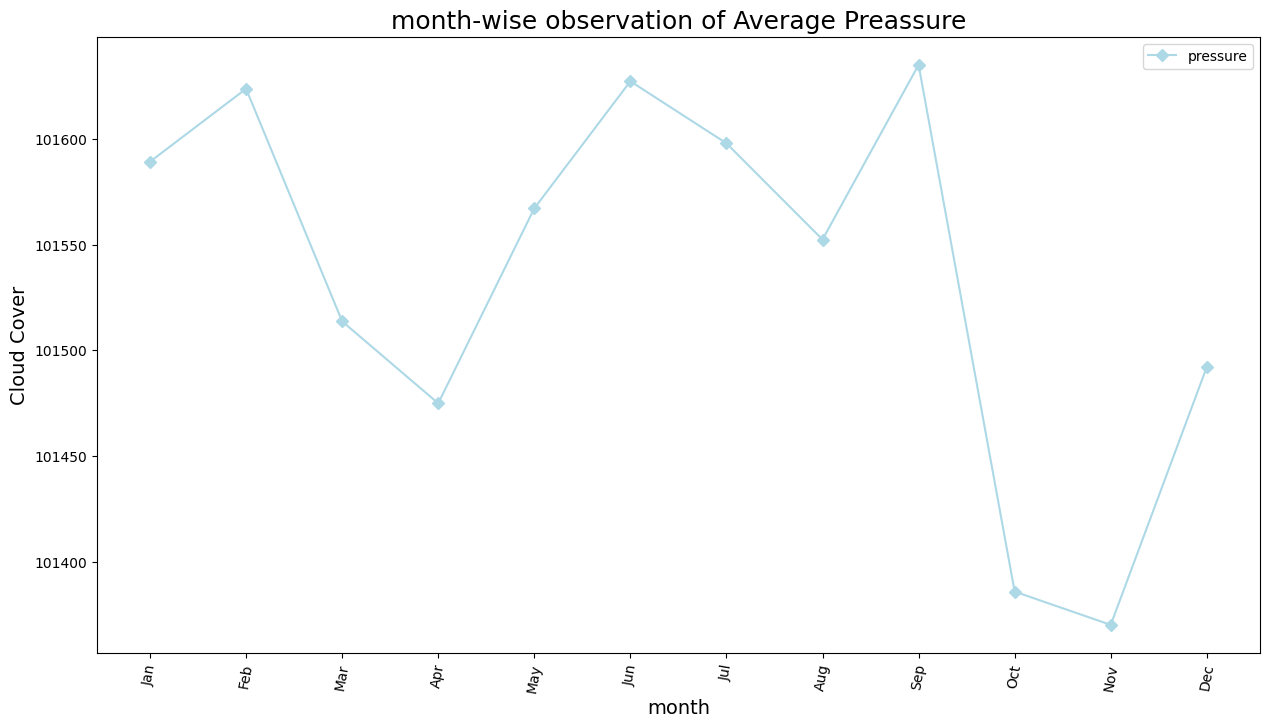

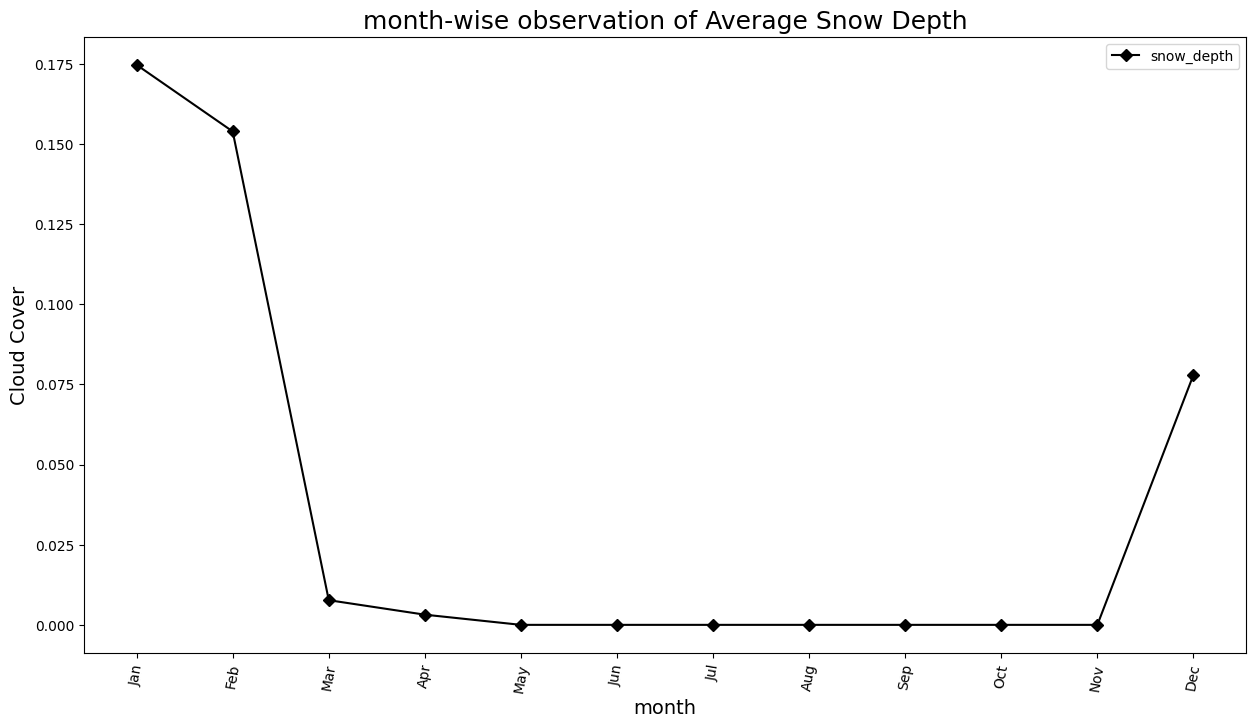

In [3]:
# ==============================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================

# -------------------------------------------
#STEP1: PREPROCESSING (AFTER DATA CLEANING)
# -------------------------------------------
features = [
    'month',
    'cloud_cover',
    'sunshine',
    'global_radiation',
    'max_temp',
    'mean_temp',
    'min_temp',
    'precipitation',   
    'pressure',
    'snow_depth'
]
# 1.1. SEPERATE TARGET AND PREDICTORS
X = df[features]        # Features
y = df['RainTomorrow']  # Target Variable
print("SEPERATE TARGET AND PREDICTORS")
print("X shape:", X.shape)
print("y shape:", y.shape)

# 1.2. TRAIN/TEST SPLIT (STRATIFIED)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("TRAIN/TEST SPLIT")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# -------------------------------------------
#STEP2: PLOT GRAPHS
# -------------------------------------------

# 2.1. FEATURE DISTRIBUTION
def plotDist(x,title):
    sns.displot(df, x=x, hue='RainTomorrow', kde=True)
    plt.title(title, fontsize = 14)
    plt.show()
plotDist("max_temp","Maximum Temperature Distribution")
plotDist("min_temp","Minimum Temperature Distribution")
plotDist("cloud_cover","Cloud Cover Distribution")
plotDist("sunshine","Sunshine Distribution")
plotDist("global_radiation","Global Radiation Distribution")
plotDist("precipitation","Today's precipitation Distribution")
plotDist("pressure","Presure Distribution")
plotDist("snow_depth","Snow depth Distribution")

# 2.2. AVERAGE NUMBER OF RAINED DAYS PER MONTH
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x='month', y='RainTomorrow', estimator=np.mean, color='blue')
plt.title('Average Number of Rained Days per month')
plt.xlabel('month')
plt.ylabel('Average Number of Rained Days')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

#2.3. month-WISE OBSERVATION
avg_df = df.groupby(['month'])[features[1:]].mean()

avg_df = avg_df.reset_index()
avg_df.head()
x = avg_df .loc[:, 'month']
y1 = avg_df['min_temp'] 
y2 = avg_df['max_temp']
y3 = avg_df['mean_temp']
plt.figure(figsize = (15, 8))
plt.plot(x, y1, marker='D', color = 'darkgreen', label = 'Minimum_Temperature') 
plt.plot(x, y2, marker='D', color = 'darkorange', label = 'Maximum Temperature')
plt.plot(x, y3, marker='D', color = 'orange', label = 'Average Temperature')
plt.xlabel('month', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('month-wise observation of Average Temperature', fontsize = 18)
plt.legend(fontsize = 10, loc = 'best')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],rotation=80)
plt.show()

def monthWiseObs(y,yLab,color):
    y1 = avg_df[y] 
    plt.figure(figsize = (15, 8))
    plt.plot(x, y1, marker='D', color = color, label = y) 
    plt.xlabel('month', fontsize = 14)
    plt.ylabel('Cloud Cover', fontsize = 14)
    plt.title(f'month-wise observation of Average {yLab}', fontsize = 18)
    plt.legend(fontsize = 10, loc = 'best')
    plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],rotation=80)
    plt.show()

monthWiseObs("cloud_cover","Cloud Cover","darkgray")
monthWiseObs("sunshine","Sun Shine","yellow")
monthWiseObs("global_radiation","Global radiation","red")
monthWiseObs("precipitation","Precipitation","darkblue")
monthWiseObs("pressure","Preassure","lightblue")
monthWiseObs("snow_depth","Snow Depth","black")


In [4]:
# ==============================================================
# 4. MODEL TRAINING
# ==============================================================

# -------------------------------------------
#STEP1 Hyperparameter Tuning for Random Forest
# -------------------------------------------

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Parameters Found:")
print(grid.best_params_)

best_rf = grid.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters Found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}



📌 Tuned Random Forest Results
Accuracy: 0.7041516835567179

Confusion Matrix:
 [[1788  344]
 [ 561  366]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      2132
           1       0.52      0.39      0.45       927

    accuracy                           0.70      3059
   macro avg       0.64      0.62      0.62      3059
weighted avg       0.69      0.70      0.69      3059



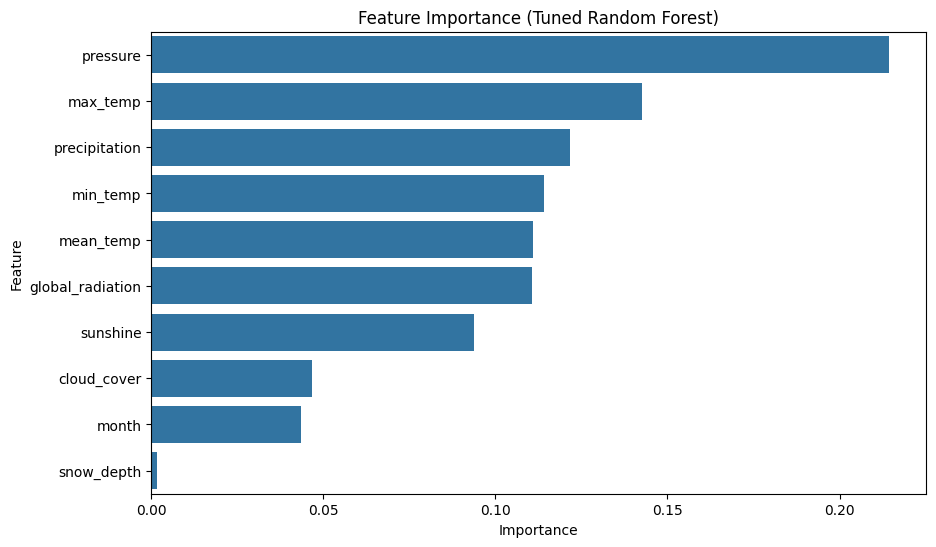

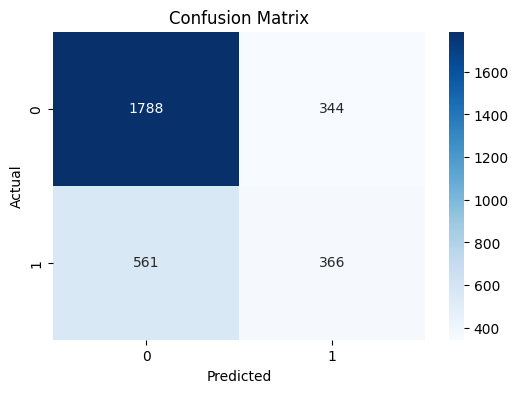


Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      2132
           1       0.52      0.39      0.45       927

    accuracy                           0.70      3059
   macro avg       0.64      0.62      0.62      3059
weighted avg       0.69      0.70      0.69      3059


Evaluation complete. Results saved in results_df.


In [ ]:
# ==============================================================
# 5. EVALUATE MODEL
# ==============================================================

# -------------------------------------------
#STEP1. Evaluate Fine-Tuned Model
# -------------------------------------------

y_pred_rf = best_rf.predict(X_test)

print("\n📌 Tuned Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# -------------------------------------------
#STEP2. Feature Importance
# -------------------------------------------

importances = best_rf.feature_importances_
fi = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(
    by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=fi, x='Importance', y='Feature')
plt.title("Feature Importance (Tuned Random Forest)")
plt.show()

# -------------------------------------------
#STEP3. FINAL OUTCOME / INSIGHTS 
# -------------------------------------------

# 3.1. Predict on the test set
y_pred = best_rf.predict(X_test)

# 3.2. Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3.3. Plot the matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#3.4. Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

#3.5. Save Result

results_df = pd.DataFrame({
    "Actual": y_test,
    "Prediction": y_pred,
    "Residual": y_test - y_pred,
})
results_df=results_df.reset_index(drop=True)
results_df.to_csv("../src/london_weather_result.csv", index=True)

print("\nEvaluation complete. Results saved in results_df.")
